# Time Series Forecasting

Time is continious. It does not stop, wait or reverse for events. The present is documented, that is why we can look back at events from the past. But is it possible to predict events from the future?

Building a model that predicts future values is a dream of data scientists around the world. What is needed for such a model? And how can you transform data to a peak into the future?

Use will be made of two datasets:

#### Shampoo Sales (Univariate Dataset)
* Month: 1998-2000 (Monthly)
* Sales: Sales for the respective month


#### Ozone Level Detection (Multivariate Dataset)

All the attribute start with T means the temperature measured at different time throughout the day; 

and those starts with WS indicate the wind speed at various time.

* WSR_PK: continuous. peek wind speed -- resultant (meaning average of wind vector)

* WSR_AV: continuous. average wind speed

* T_PK: continuous. Peak T
* T_AV: continuous. Average T
* T85: continuous. T at 850 hpa level (or about 1500 m height)
* RH85: continuous. Relative Humidity at 850 hpa
* U85: continuous. (U wind - east-west direction wind at 850 hpa)
* V85: continuous. V wind - N-S direction wind at 850
* HT85: continuous. Geopotential height at 850 hpa, it is about the same as height at low altitude
* T70: continuous. T at 700 hpa level (roughly 3100 m height)

* RH70: continuous.
* U70: continuous.
* V70: continuous.
* HT70: continuous.

* T50: continuous. T at 500 hpa level (roughly at 5500 m height)

* RH50: continuous.
* U50: continuous.
* V50: continuous.
* HT50: continuous.

* KI: continuous. K-Index 
* TT: continuous. T-Totals
* SLP: continuous. Sea level pressure
* SLP_: continuous. SLP change from previous day

* Precp: continuous. -- precipitation

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn as sk
import statsmodels.api as sm

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', mpl.__version__)

numpy version: 1.19.5
pandas version: 1.2.4
scikit-learn version: 0.24.1
matplotlib version: 3.3.4


In [2]:
shampoo = pd.read_csv('/Users/matt/Desktop/AI/PersonalNotebooks/ML/TimeSeriesForecasting/shampoo.csv',
                     #header=0,
                     #index_col=0)
                     ).iloc[:]
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [3]:
shampoo.tail()

,Month,Sales
31,3-08,407.6
32,3-09,682.0
33,3-10,475.3
34,3-11,581.3
35,3-12,646.9


The data looks pretty much ready to use! With only 2 rows available we cant do a lot of feature selection. What we can do is enhance them. Lets start treating the dataset.

## Exploring the dataset

In [4]:
shampoo.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [5]:
shampoo.isnull().sum()

Month    0
Sales    0
dtype: int64

In [6]:
shampoo.isna().sum()

Month    0
Sales    0
dtype: int64

In [7]:
print('Minimum {0}'.format(shampoo.min()))
print('Maximum {0}'.format(shampoo.max()))

Minimum Month     1-01
Sales    119.3
dtype: object
Maximum Month     3-12
Sales    682.0
dtype: object


Luckily all the sales are a float so we dont have to worry about conversion.

Only problem left is the date. It is not really representative of the time period.

In [8]:
shampoo['Month'] = sm.tsa.datetools.dates_from_range('1998m1', '2000m12')
shampoo.head()

,Month,Sales
0,1998-01-31,266.0
1,1998-02-28,145.9
2,1998-03-31,183.1
3,1998-04-30,119.3
4,1998-05-31,180.3


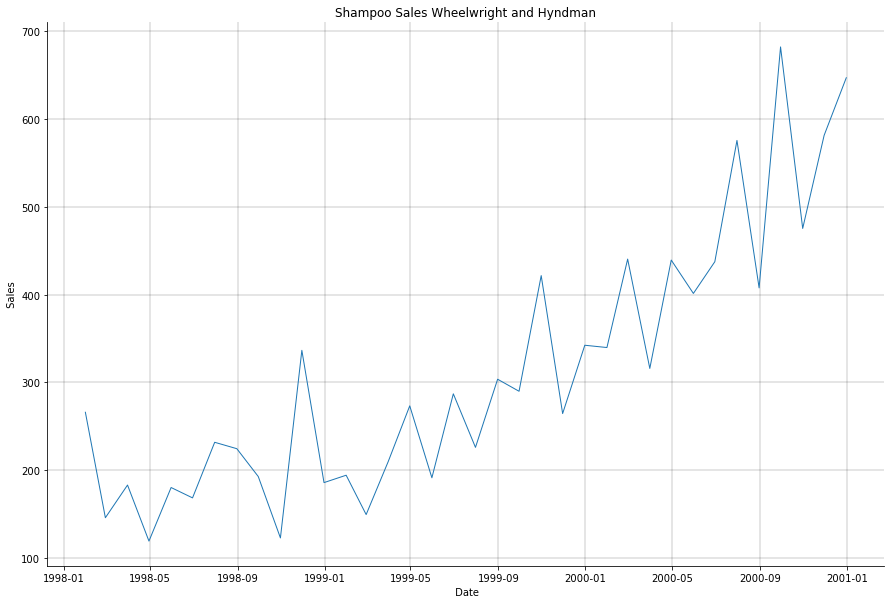

In [9]:
import matplotlib.pyplot as plt
import math

fig, ax = plt.subplots(figsize=(15, 10))

def lineplot(sales, date):
    x = date
    y = sales
    
    ax.plot(x, y, linewidth=1)

    #add title and axes labels
    ax.set_title('Shampoo Sales Wheelwright and Hyndman')
    ax.set_xlabel(' Date')
    ax.set_ylabel(' Sales ')
    
    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #adds major gridlines
    ax.grid(color='black', linestyle='-', linewidth=0.2, alpha=1)
    
    plt.show()

lineplot(shampoo.Sales, shampoo.Month)

## Introduction to Time Series Forecasting Algorithms

For a start, what does ARIMA even mean?

ARIMA is an acronym for 'Auto Regressive Integrated Moving Avarage'. In short, it is a class of models which predicts a given time series based on its own past values. 

Any non-seasonal time series that exhibits patterns and is not randomly generated white noise can be modeled with ARIMA models.

An ARIMA model has 3 terms: _p_, _d_ and _q_

* p - order of AR
* q - order of MA
* d - differencing necessary to make times series stationary

If a time series has seasonal patterns, then seasonal terms have to be added and it becomes: SARIMA, short for Seasonal ARIMA.

### What is the meaning of _p_, _q_ and _d_?

One of the first steps to building an ARIMA model is making the time series stationary. Because the term 'Auto Regressive' in ARIMA it means this algorithm is a _linear regression model_ that uses its own lags as predictors.

**Linear regression models work best when the predictors are not correlated and independent of each other**

One of the main ways of making a series stationary is to difference it. As in subtract the previous value from the current value. Depending on the complexity, more than one differentation might be needed.

therefore, the value of _d_ is the minimum number of differentations needed to make the series stationary. If the series is already stationary then d=0.

_p_ is the Auto Regressive (AR) term. It specifies the number of lags of Y to be used as predictors. 

_q_ is the Moving Avarage (MA) term. It refers to the number of lagged forecast errors that should be incorporated in the model.

### What are the AR and MA models?

A pure Auto Regressive model is one where _Yt_ depends only on its own lags.

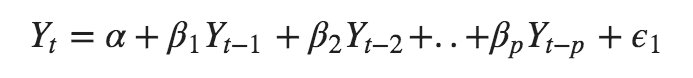

where, $Y{t-1}$ is the lag1 of the series, $\beta1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

Just like a pure AR model, a pure Moving Avarage (MA) model is one where _Yt_ depends only on the lagged forecast errors.

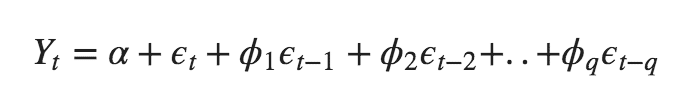

The error terms are the errors of the AR models on the respective lags.

To sum everything up, what is the equation of an ARIMA model?

As noted before, an ARIMA model is differenced at least once to make it stationary and then a combination of AR and MA terms is applied.

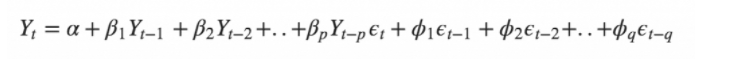

In other words: Predicted _Yt_ = _Constant_ + _Linear combination lags of Y (up to p lags)_ + _Linear combination of lagged forecast errors (up to q lags)_

Therefore the objective of making an ARIMA model can be constructed as identifying the values of **p**, **d** and **q**

### Finding the 'order of differentation' d 

The main purpose of differencing is making the time series stationary. Over-differencing is a real issue, which in turn will display the model to be stationary, but the parameters will be affected. And thus the accuracy of the model will be worse.

The most applicable order of `d` is the minimum differencing required to get a near stationary series. This series roams around a defined mean and the `ACF` plot reaches zero fairly quick.

If the autocorrelation of many lags (>10) is positive. Further differencing is needed.
The autocorrelation of the first lag can be too negative. This is a result of over differencing. 

Lets first check if the series is stationary using the _Augmented Dicky Fuller Test_, `adfuller()`, from the statsmodel package.

This is a good first checkup because differencing is only necessary if the series is non-stationary. If the series is already stationary then we can assume: `d=0`

The null hypothesis of the ADF test is a non-stationary series. If the p-value is lower than the significance level (0.05) then the null hypothesis is redacted and the time series is indeed stationary.

#### ADF Test

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(shampoo.Sales)

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


From this we can see the p-value is a lot higher than the significance level. Hence, the series is not-stationary. So we can assume the order of differencing is not 0 and we have do to some further analysis.

#### KPSS test

In [11]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(shampoo.Sales)

Results of KPSS Test:
Test Statistic           0.752776
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\matt\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The null hypothesis of the kpss test is reversed. If the p-value is higher than the significance level, the hypothesis cannot be rejected and thus the series is stationary. In this case it might be smaller because of the error given. But from the result of the ADF test we can assume that it is not stationary.

### Autocorrelation Plot

Datasets for prediciting future values can be categorized into 2 groups.

1. A Time Series refers to observations of a specific variable over a specified time. For example the avarage daily temperature over the past 10 years.
2. Cross-sectional data refers to observations of many variables at a single point in time.

An autocorellation plot shows whether the elements of a time series are positively correlated, negatively correlated or independent of eachother.

The plot shows the value of the autocorellation function on the vertical axis. It ranges from 1 to -1

On the horizontal axis of the plot the size of lag between the elements is displayed. i.e. the autocorrelation with lag _x_ is the correlation between the time series elements and the corresponding elements that were observed _x_ time periods earlier.

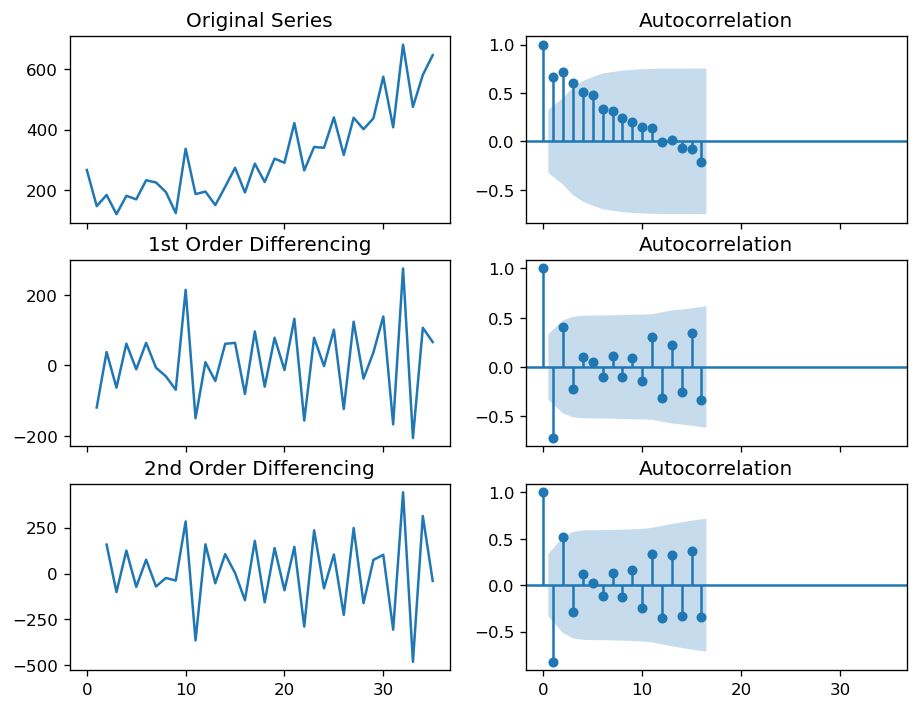

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(shampoo.Sales); axes[0, 0].set_title('Original Series')
plot_acf(shampoo.Sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(shampoo.Sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(shampoo.Sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(shampoo.Sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(shampoo.Sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Finding the 'order of AutoRegressive' p

In order to find if the model needs any `AR` terms or what they are specifically we can use the `PACF` 'Partial Autocorrelation' plot. But how does it work?

PACF can be considered as the correlation between the series and its lag, after excluding contributions from the intermediate lags. In short: PACF conveys the pure correlation between a lag and the series. This way we can find out if that lag is required in the `AR` term or not.

Any autocorrelation in a stationarized series can be rectified by adding `AR` terms. So for a start the order of AR will be equal to the lags that crosses the significance limit in the `PACF` plot.

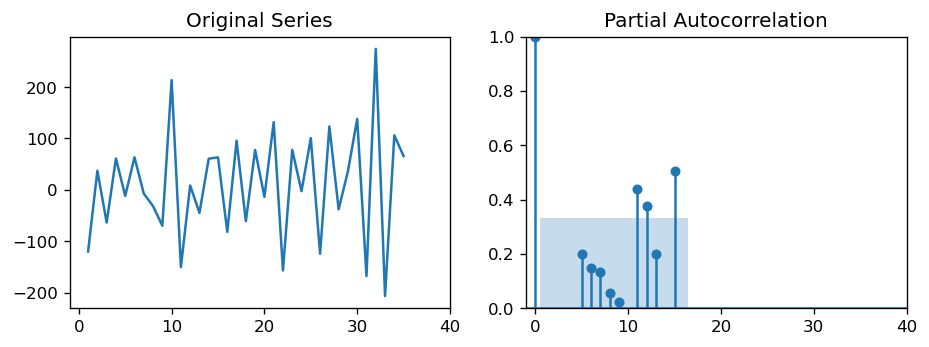

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(shampoo.Sales.diff().dropna()); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,1), xlim=(-1,40))
plot_pacf(shampoo.Sales.diff().dropna(), ax=axes[1])

plt.show()

From these graphs we can see that quite a few lags are above the significance level. It drops off significantly after at lag 3. 

For now we will keep the term at `p=1`

### Finding the 'order of MA' q

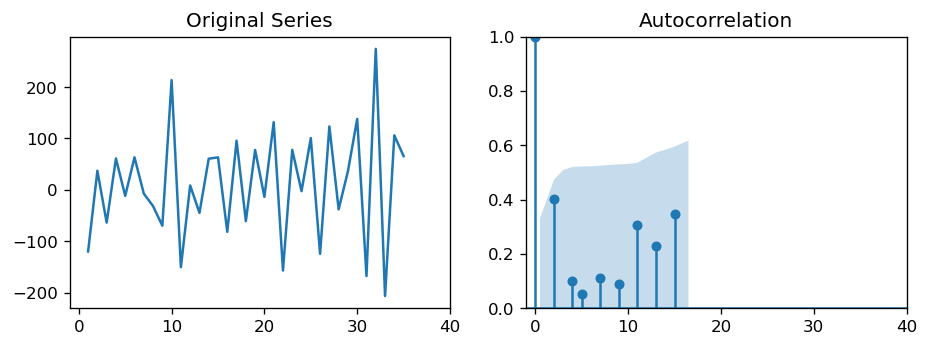

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(shampoo.Sales.diff().dropna()); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,1), xlim=(-1, 40))
plot_acf(shampoo.Sales.diff().dropna(), ax=axes[1])

plt.show()

Here we can see that there is one lag that is above the significance value. So for now we will assume that `q=2`

### Over differencing

From above examples we can see that it is not quite clear yet what the correct values are. But it is never a sure case. That is why experimentation is needed. 

In general. If a series is slightly over differenced. Adding an AR term can even this out. Playing around with the values is important. But also visualizing the data, this helps working towards a conclusion with direct evidence.

## Building the ARIMA model

Now that we have the values for p, q and d we can start implementing the ARIMA model.

`p=1`

`d=1`

`q=2`

In [15]:
from statsmodels.tsa.arima.model import ARIMA

def arima_model(p, d, q, data):
    model = ARIMA(data, order=(p, d, q))
    model_fit = model.fit()
    return model_fit

#1,1,1 ARIMA
arima1 = arima_model(1, 1, 2, shampoo.Sales)

arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -196.631
Date:                Wed, 15 Sep 2021   AIC                            401.263
Time:                        18:32:46   BIC                            407.484
Sample:                             0   HQIC                           403.411
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0894      0.346      0.258      0.796      -0.589       0.768
ma.L1         -1.3186      2.951     -0.447      0.655      -7.103       4.466
ma.L2          0.9944      4.393      0.226      0.821      -7.616       9.605
sigma2      3747.0262   1.63e+04      0.230      0.818   -2.81e+04    3.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.96   Prob(JB):                         0.99
Heteroskedasticity (H):               1.04   Skew:                             0.03
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For now lets stick to ARIMA(1,1,2) as it gives good results for the beginning. But the `AIC` is relatively low, so this is a good indicator that this is the best fit for this particular ARIMA model. 

Later on the values for ARIMA will be calculated using a different method

Plotting the residuals to ensure there are no patterns. Looking for constant and mean variance.

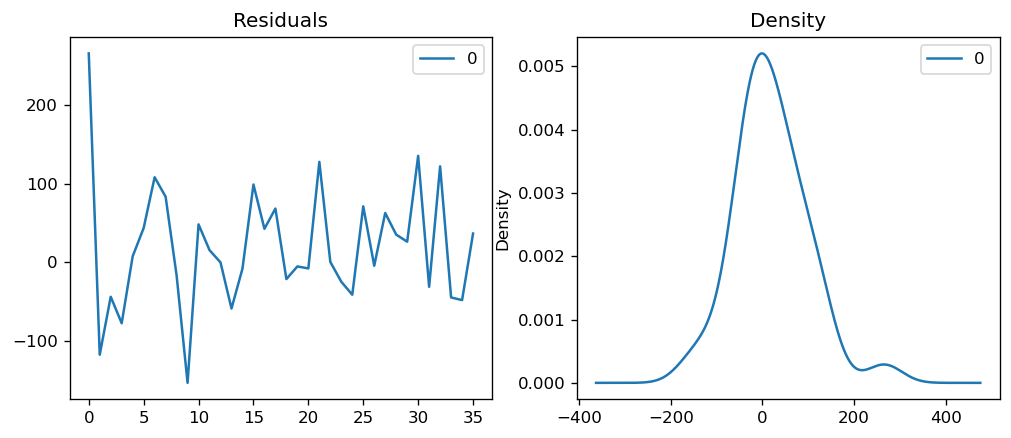

In [16]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})

residuals = pd.DataFrame(arima1.resid)

fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

With a near 0 mean and uniform variance the errors seem to be acceptable.

Now its time to plot the actual vs predicted values

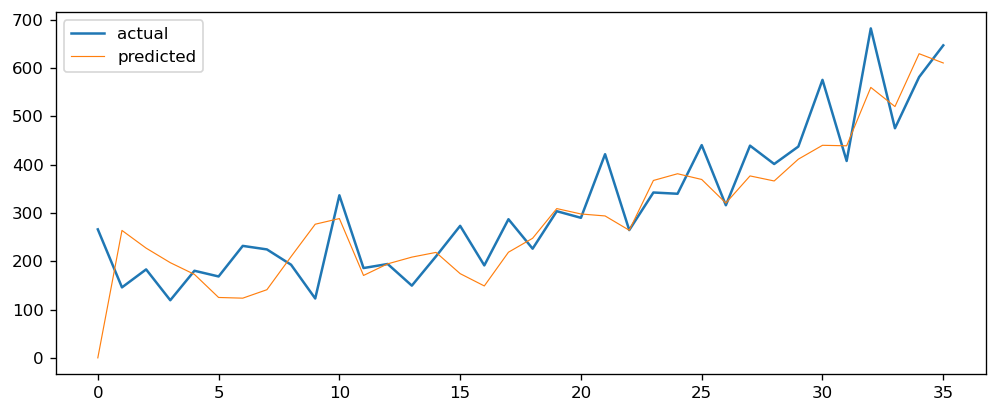

In [17]:
predicted1 = arima1.predict(dynamic=False)

fig, ax = plt.subplots(1, 1)
ax.plot(shampoo.Sales, label='actual')
ax.plot(predicted1, label='predicted', linewidth=0.7)
plt.legend(loc='upper left')
plt.show()

Wow! We have a model which fits the existing data pretty nicely! But we have not done any forecasting yet. So we cant say that this models is sufficient.

Lets bring this model to a test!

### Manually finding the optimal ARIMA model using Out-Of-Time Cross Validation

With Out-Of-Time Cross-Validation you take `x` steps back in time and forecast `x` steps into the future. Then the forecasts are compared against the actual results.

For this, we need a training and test set. This will be achieved by splitting the time series in an approximate ratio of 75:25

In [18]:
train = shampoo.Sales[:27]
test = shampoo.Sales[27:]

Now lets build an ARIMA model on the training dataset, forecast and plot it.

C:\Users\matt\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\matt\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIM

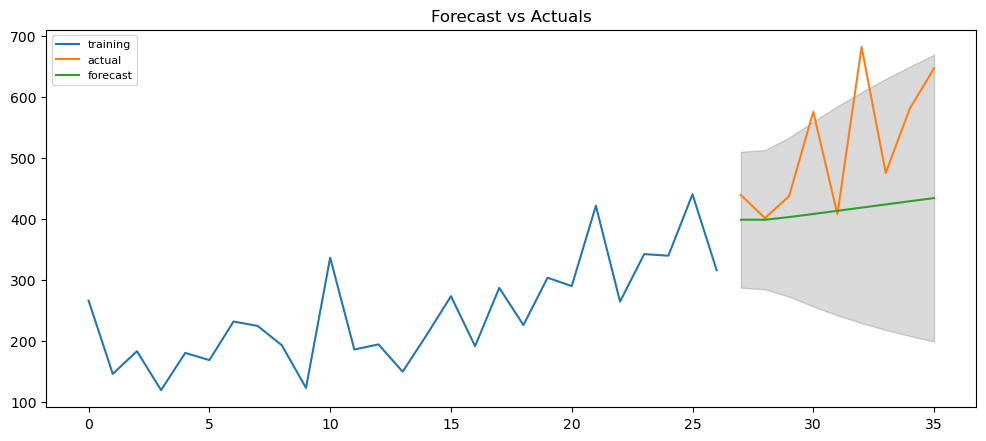

In [19]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(9, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

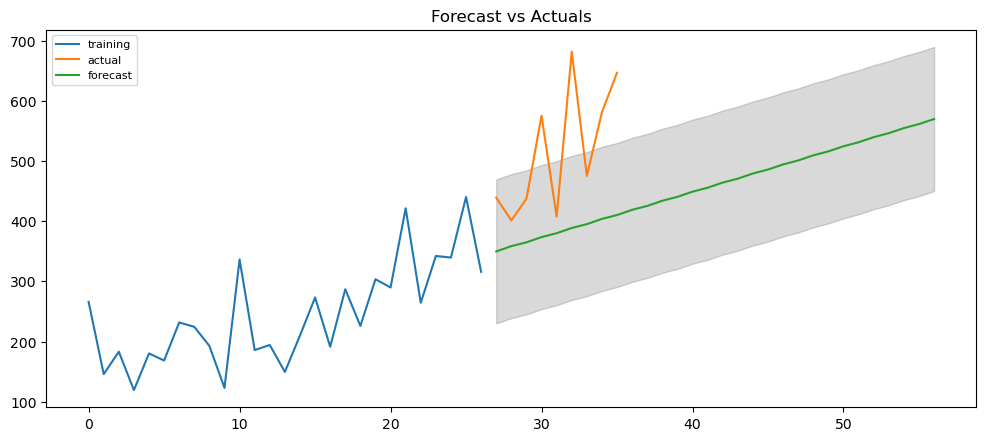

In [33]:
import pmdarima as pm
# Build Model
model = pm.arima.ARIMA(order=(1, 1, 2))  
fitted = model.fit(train)  

n_periods = 30
n_post = 21
n_pre = 9
fc, confint = fitted.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(shampoo.Sales)-n_pre, len(shampoo.Sales)+n_post)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The forecast is still a little under the actual values. Lets try `auto_arima()` from `pmdarima`.

This automatically selects the best values for `(p, d, q)`

In [38]:
auto_arima1 = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=311.842, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=298.724, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=309.854, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=300.104, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=296.226, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=296.179, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.715 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. O

### Residual plot interpretations

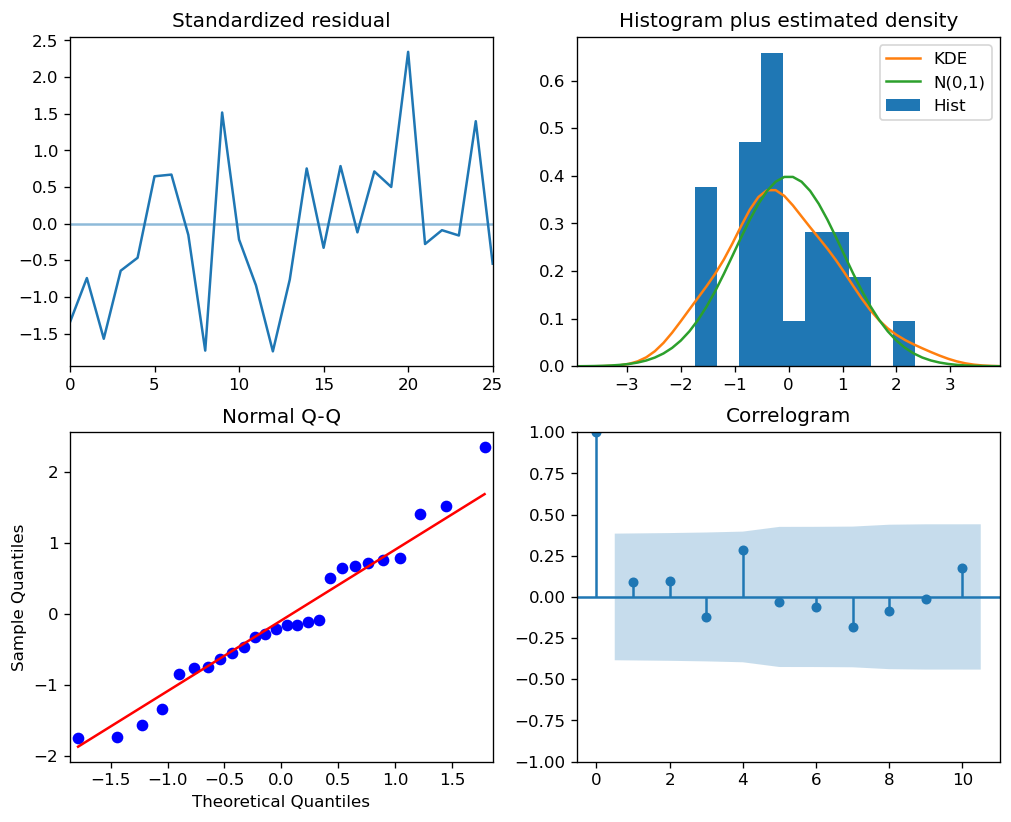

In [39]:
auto_arima1.plot_diagnostics(figsize=(10,8))
plt.show()

**Standardized Residual**: The results fluctuate around the mean point of around 0. With a slow rise.

**Histogram**: The density plot is slightly shifted to the right. This might have to do with the small data set.

**Theoretical Quantiles**: The dots move in a sin wave across the line. With no significant deviation from the line it is acceptable. If deviations are present this may suggest the distribution is skewed.

**Correlogram**: The ACF plot show the residual errors are not autocorrelated. This plot would imply there are patterns in the residual errors which would are not explained in the model. In this case the model would need more predictors.

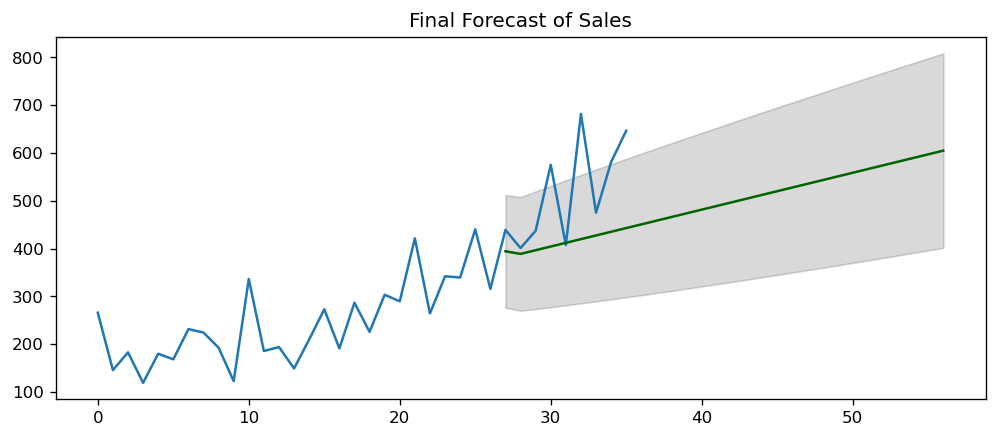

In [41]:
n_periods = 30
n_post = 21
n_pre = 9

fitted = auto_arima1.fit(train)

fc, confint = auto_arima1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(shampoo.Sales)-n_pre, len(shampoo.Sales)+n_post)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(shampoo.Sales)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Sales")
plt.show()

From this we can see that the `auto_arima()` model gives the same result.

It is a growing slope, so it gives an indication to growth in the future. But not a specific indication.

For a better representation lets take a look at another model.

## Building the SARIMA model

One of the biggest weaknesses of the ARIMA model is that it does not support seasonality. Almost all time series cases involve some kind of seasonality. 

It is in human nature for these events to happened on a seasonal basis.

The `SARIMA` model is perfect for this case. Short for Seasonal ARIMA it implements seasonal differencing.

The model is represented as `SARIMA(p,d,q)x(P,D,Q)` where P, D and Q are SAR, order of seasonal differencing and SMA terms respectively. `x` is the frequency of the time series. If the model has well defined seasonal patterns then enforce `D=1` for a frequency of `x`

We use the same `auto_arima()` method as before

In [51]:
auto_sarima1 = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

auto_sarima2 = pm.auto_arima(shampoo.Sales, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_sarima1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=187.116, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=187.133, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=192.884, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=187.166, Time=0.11 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=188.927, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=188.974, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.182 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=305.104, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=303.790, Time=0.23 se

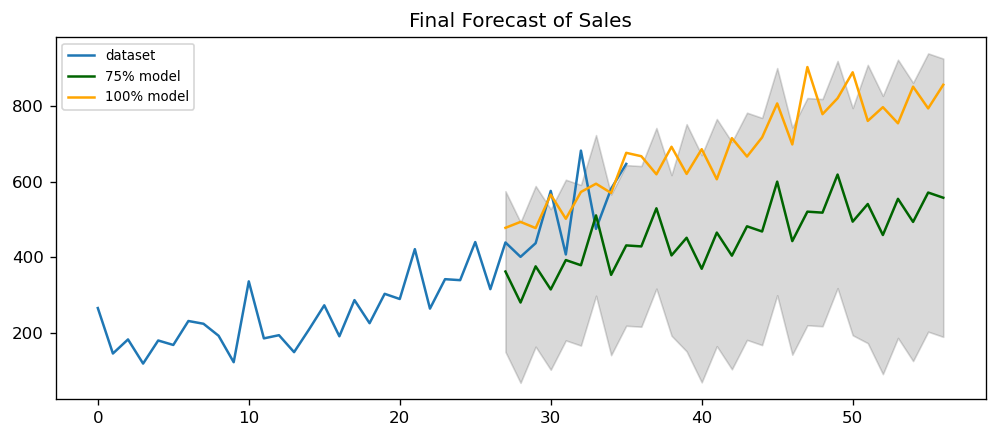

In [57]:
n_periods = 30
n_post = 21
n_pre = 9

fitted = auto_arima1.fit(train)

fc, confint = auto_sarima1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(shampoo.Sales)-n_pre, len(shampoo.Sales)+n_post)

fc2, confint2 = auto_sarima2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc2 = np.arange(len(shampoo.Sales)-n_pre, len(shampoo.Sales)+n_post)
fc_series2 = pd.Series(fc2, index=index_of_fc2)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(shampoo.Sales, label='dataset')
plt.plot(fc_series, color='darkgreen', label='75% model')
plt.plot(fc_series2, color='orange', label='100% model')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Sales")
plt.legend(loc='upper left',  fontsize=8)
plt.show()